In [32]:
%run BI_df.py
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

In [33]:
print(list(df))
print(len(list(df)))

['avg_expenditure', 'avg_incoming', 'avg_mshwari_loan', 'avg_talkTime_mins', 'branch_avg', 'branch_inst_avg', 'branch_max', 'branch_min', 'burn_rate', 'calls_d/n', 'max_expenditure', 'max_incoming', 'max_mshwari_loan', 'min_expenditure', 'min_incoming', 'mpesa_avg', 'mpesa_limit', 'mpesa_max', 'mshwari_avg', 'mshwari_competition', 'mshwari_max', 'n_branch_loans', 'n_calls', 'n_contacts', 'n_devices', 'n_expenditures', 'n_incomes', 'n_mshwari_loans', 'n_texts', 'texts_d/n', 'total_expenditure', 'total_income', 'total_mshwari_loans', 'total_talkTime_hrs', 'transaction_success', 'status']
36


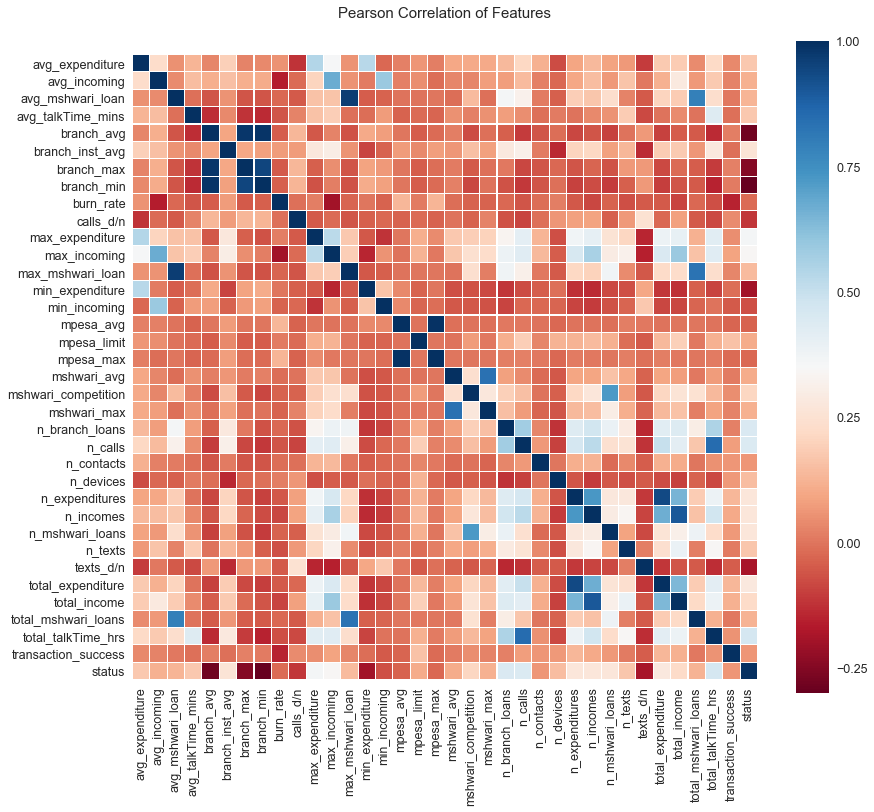

In [34]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
all_features = df.corr()
sns.heatmap(all_features.astype(float), linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=False)

# even and non-overlapping info content across the board. minimize collinearity.

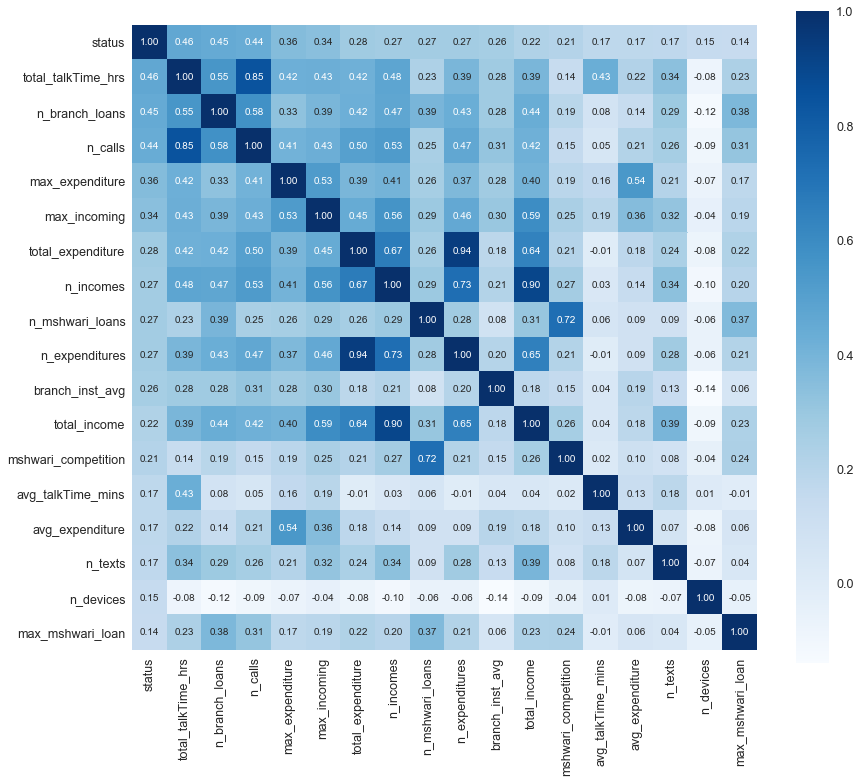

In [35]:
k = 18
plt.figure(figsize=(14,12))
cols = all_features.nlargest(k, 'status')['status'].index 
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, cmap='Blues', annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#standouts. utility of bad standouts? nsmallest

/Users/yashevde/miniconda3/envs/pYash/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/yashevde/miniconda3/envs/pYash/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


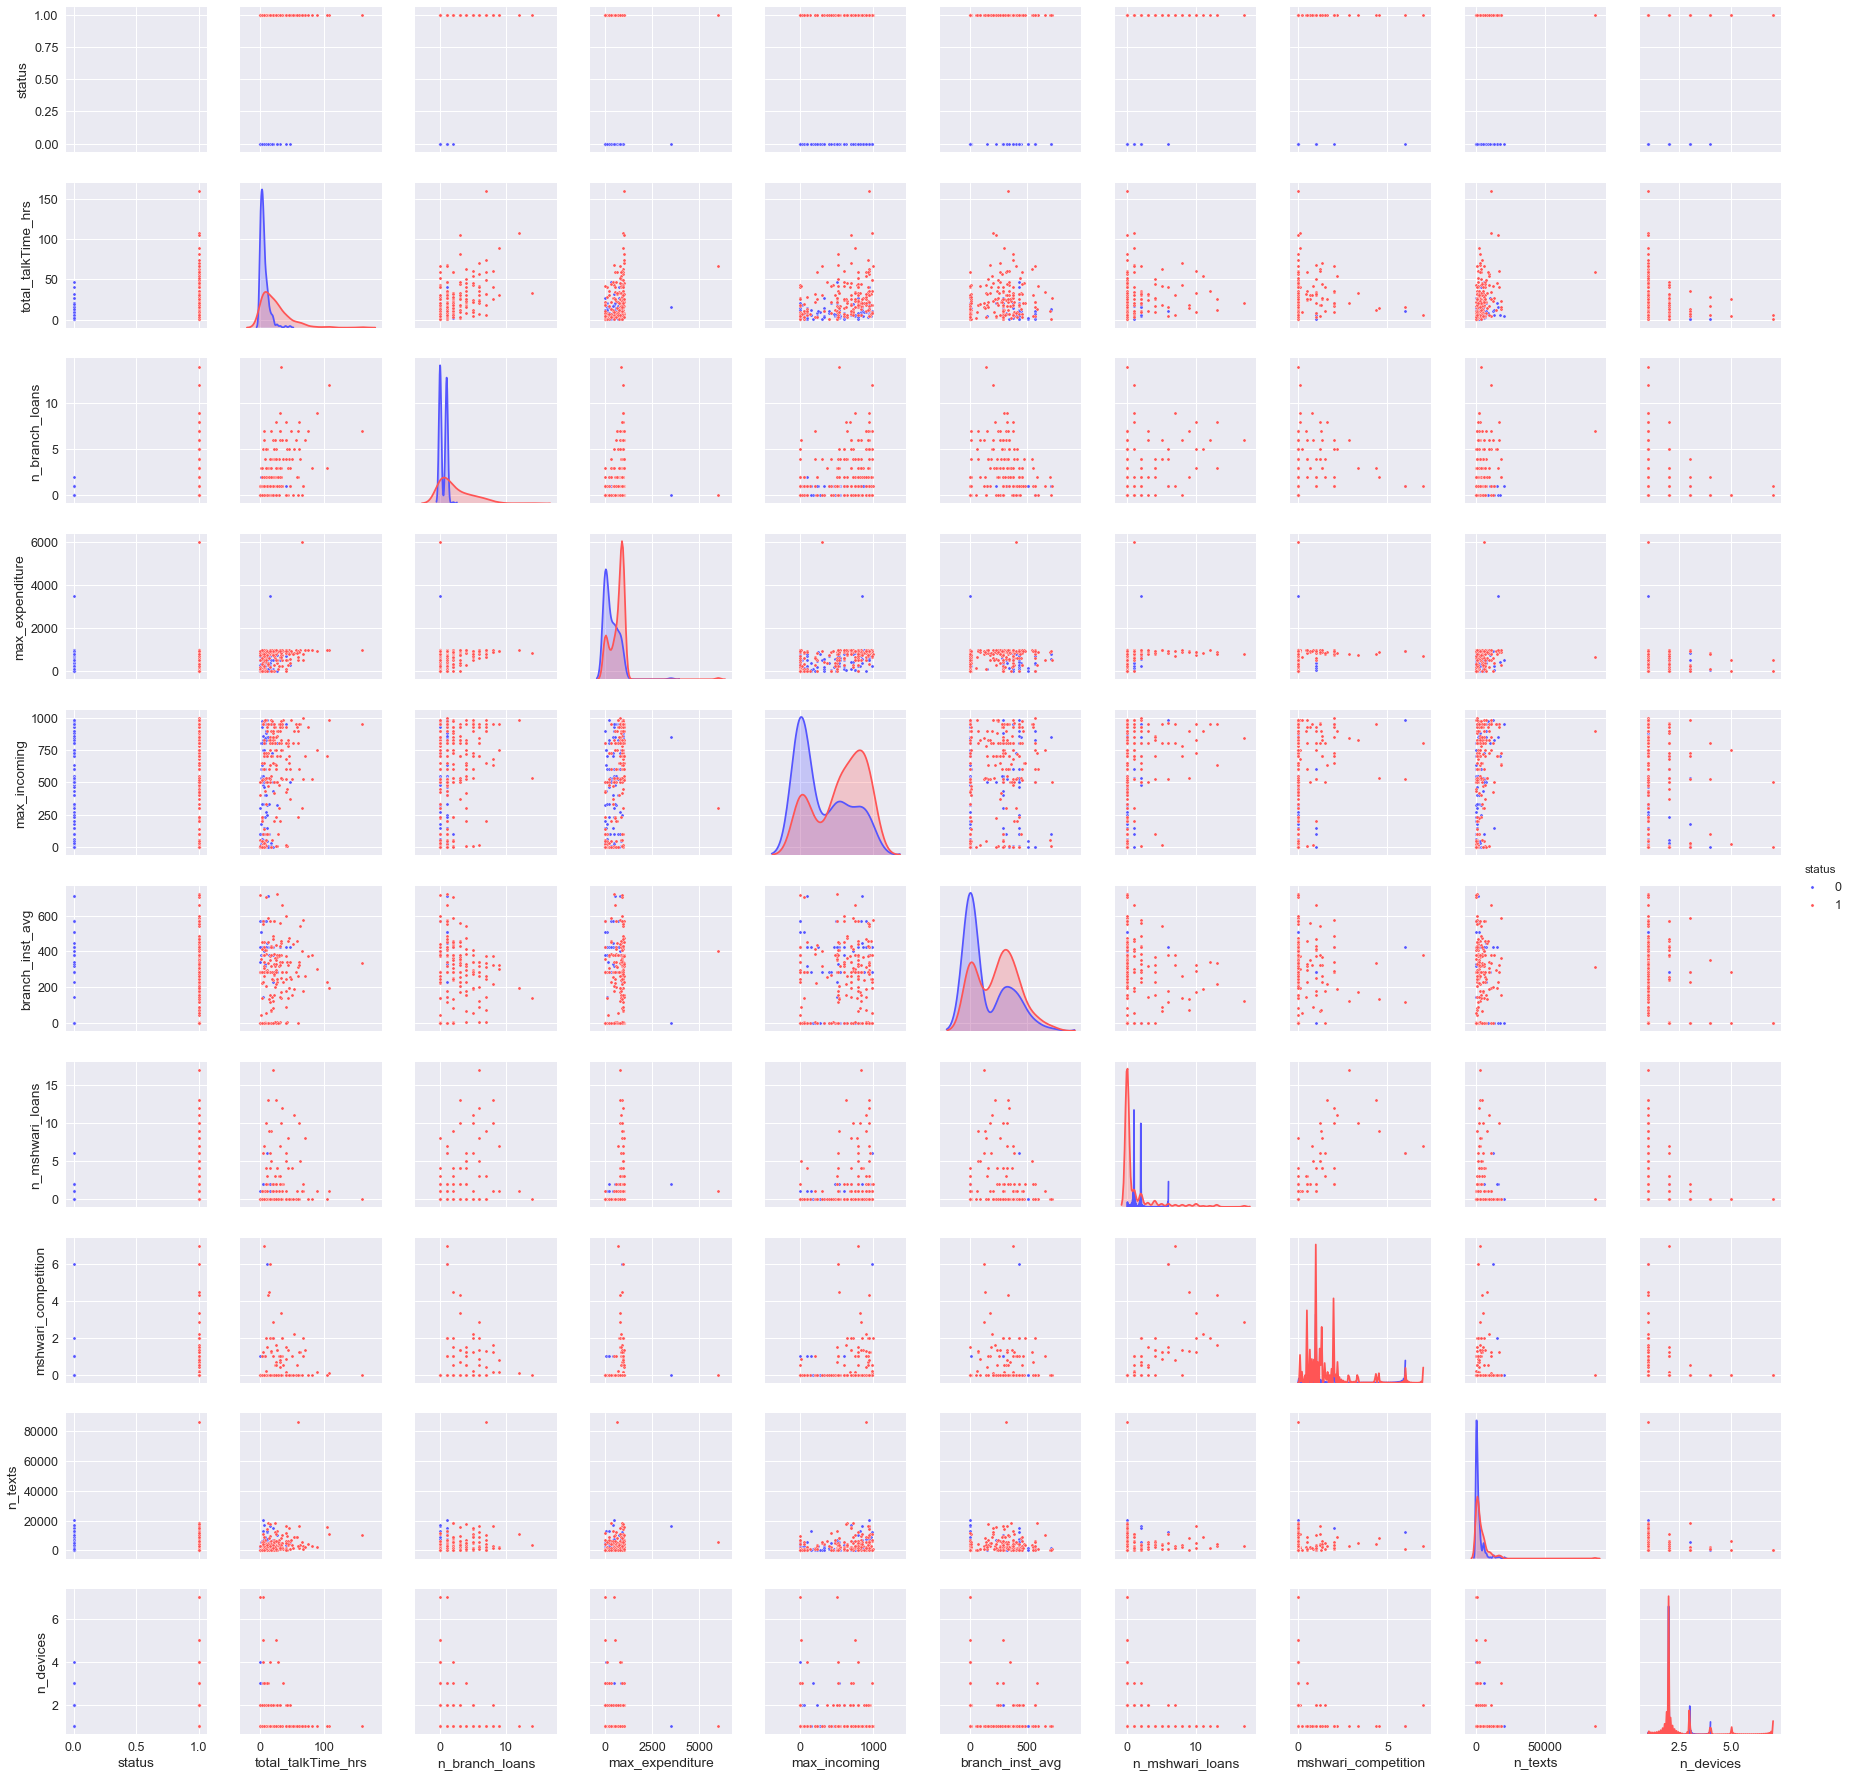

In [36]:
#minimizing collinearity with this selection of cols

pairs = ['status','total_talkTime_hrs','n_branch_loans','max_expenditure','max_incoming','branch_inst_avg','n_mshwari_loans','mshwari_competition','n_texts','n_devices']
sns.pairplot(df[pairs], size=2.5, hue='status', palette = 'seismic',diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )

In [37]:
fields = ['status','total_talkTime_hrs','n_branch_loans','max_expenditure','max_incoming','branch_inst_avg',
          'n_mshwari_loans','mshwari_competition','n_texts','n_devices']
le = LabelEncoder()
for f in fields:
    df[f] = le.fit_transform(df[f])

In [38]:
def classification_model(model, data, predictors, target):

    model.fit(data[predictors], data[target])
    predictions = model.predict(data[predictors])
    accuracy = metrics.accuracy_score(predictions,data[target])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))

    #k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:

        train_predictors = (data[predictors].iloc[train,:])
        train_target = data[target].iloc[train]
    
        model.fit(train_predictors, train_target)
        error.append(model.score(data[predictors].iloc[test,:], data[target].iloc[test]))
 
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    model.fit(data[predictors],data[target]) 

In [39]:
target = 'status'
model = LogisticRegression()
predictors = ['total_talkTime_hrs','n_branch_loans','max_expenditure','max_incoming', 'branch_inst_avg', 'mshwari_competition']
classification_model(model, train, predictors, target)

#adding additional features isn't having much of an effect. Top ones are dominant

print(model.coef_)
#magnitude of predictor coefficient * standard deviation of the corresponding parameter in the data 
#would give a sense for the contributions

Accuracy : 80.312%
Cross-Validation Score : 78.438%
[[ 9.67950685e-02  7.26391146e-01  6.02879936e-04 -4.36669640e-04
  -2.65555149e-04  1.87139848e-01]]


In [40]:
target = 'status'
model = DecisionTreeClassifier()
predictors = ['total_talkTime_hrs','n_branch_loans','max_expenditure','max_incoming', 'branch_inst_avg', 'mshwari_competition']
classification_model(model, train, predictors, target)

#accuracy up, CV score down: overfitting

contribution = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
print(contribution)

Accuracy : 100.000%
Cross-Validation Score : 73.750%
n_branch_loans         0.387471
total_talkTime_hrs     0.280370
max_expenditure        0.165081
max_incoming           0.086243
branch_inst_avg        0.071048
mshwari_competition    0.009786
dtype: float64


In [41]:
target = 'status'
model = RandomForestClassifier()
predictors = ['total_talkTime_hrs','n_branch_loans','max_expenditure','max_incoming', 'mshwari_competition', 'mshwari_competition']
classification_model(model, train, predictors, target)

#still over fit. tune parameters, reduce n_predictors

contribution = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
print(contribution)

Accuracy : 98.438%
Cross-Validation Score : 79.375%
total_talkTime_hrs     0.337484
n_branch_loans         0.270604
max_expenditure        0.217051
max_incoming           0.142726
mshwari_competition    0.016897
mshwari_competition    0.015238
dtype: float64


In [42]:
target = 'status'
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictors = ['total_talkTime_hrs','n_branch_loans','max_expenditure','max_incoming', 'mshwari_competition']
classification_model(model, train, predictors, target)

#generalizing well. expected higher CV score

contribution = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
print(contribution)

Accuracy : 84.688%
Cross-Validation Score : 82.188%
total_talkTime_hrs     0.423241
n_branch_loans         0.230917
max_expenditure        0.162217
max_incoming           0.131663
mshwari_competition    0.051961
dtype: float64


In [ ]:
#confusion matrix

Skewness: 0.030534
Kurtosis: -1.204525


/Users/yashevde/miniconda3/envs/pYash/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


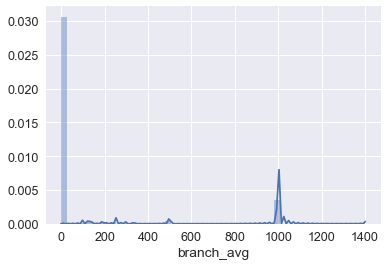

In [29]:
sns.distplot(df['branch_avg'])
print("Skewness: %f" % df['total_talkTime_hrs'].skew())
print("Kurtosis: %f" % df['total_talkTime_hrs'].kurt())

Skewness: 0.030534
Kurtosis: -1.204525


/Users/yashevde/miniconda3/envs/pYash/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


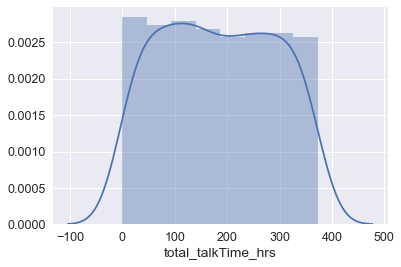

In [28]:
sns.distplot(df['total_talkTime_hrs'])
print("Skewness: %f" % df['total_talkTime_hrs'].skew())
print("Kurtosis: %f" % df['total_talkTime_hrs'].kurt())

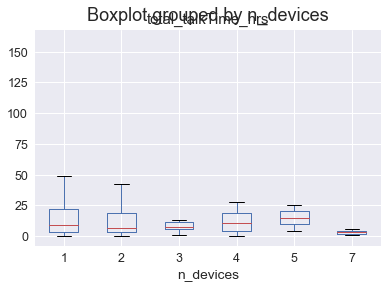

In [11]:
train.boxplot(column='total_talkTime_hrs', by='n_devices')